# Prompt Tips for Code Generation 
> *This notebook runs on conda_python3. To test the generated code, you'd better use vscode in your local env.

## Introduction

This demo gathers some tips on Code generation. This field keeps evolving super fast, we will keep finding and refreshing tips on a regular basis.
In this demo, we use Claude V2 to test the LLM capacity for code generation.

## Setup

Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.


In [1]:
%pip install boto3 --upgrade
%pip install --quiet langchain --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import json
import os
import sys

import boto3

boto3_bedrock = boto3.client(service_name='bedrock-runtime')



In [9]:
from langchain.llms.bedrock import Bedrock

inference_modifier = {'max_tokens_to_sample':4096, 
                      "temperature":1,
                      "top_k":10,
                      "top_p":1,
                      "stop_sequences": ["\n\nHuman"]
                     }

textgen_llm = Bedrock(model_id = "anthropic.claude-v2",
                    client = boto3_bedrock, 
                    model_kwargs = inference_modifier 
                    )


## 场景一

体验使用自然语言描述一个比较复杂逻辑.通过代码生成得到完整的实现

In [10]:
requir_str = """
1. Create a list of movies
2. Create a list of ratings for these movies
3. Combine them to make a json object of 10 movies with their ratings.
"""

In [22]:
from langchain import PromptTemplate

# Create a prompt template that has multiple input variables
coder_prompt = PromptTemplate(
    input_variables=["reqirement", "programmingLanguage"], 
    template="""

Human: You will be acting as an expert software developer in {programmingLanguage}. 
Please generate runnable code according to the following requirements.
<reqirement>
{reqirement}
</reqirement>

Assistant:"""
)

# Pass in values to the input variables
prompt = coder_prompt.format(reqirement=requir_str, programmingLanguage="python")


### Generate the code according to requirement using Amazon Bedrock Claudev2 and LangChain

In [13]:
response = textgen_llm(prompt)

code_explanation = response[response.index('\n')+1:]

print(code_explanation)


```python
import json

movies = ["The Shawshank Redemption", "The Godfather", "The Dark Knight", "12 Angry Men", 
          "Schindler's List", "Pulp Fiction", "The Lord of the Rings: The Return of the King", 
          "The Good, the Bad and the Ugly", "Fight Club", "Forrest Gump"]

ratings = [9.2, 9.2, 9.0, 8.9, 8.9, 8.9, 8.9, 8.8, 8.8, 8.8]

movie_dict = []
for i in range(10):
    movie_dict.append({"title": movies[i], "rating": ratings[i]})

movie_json = json.dumps(movie_dict)

print(movie_json)
```

This creates a list of 10 popular movies, a corresponding list of ratings, combines them into a list of dictionaries, and dumps that list into a JSON string.


### test

Testing the generated code

In [14]:
import json

movies = ["The Shawshank Redemption", "The Godfather", "The Dark Knight", "12 Angry Men", 
          "Schindler's List", "Pulp Fiction", "The Lord of the Rings: The Return of the King", 
          "The Good, the Bad and the Ugly", "Fight Club", "Forrest Gump"]

ratings = [9.2, 9.2, 9.0, 8.9, 8.9, 8.9, 8.9, 8.8, 8.8, 8.8]

movie_dict = []
for i in range(10):
    movie_dict.append({"title": movies[i], "rating": ratings[i]})

movie_json = json.dumps(movie_dict)

print(movie_json)

[{"title": "The Shawshank Redemption", "rating": 9.2}, {"title": "The Godfather", "rating": 9.2}, {"title": "The Dark Knight", "rating": 9.0}, {"title": "12 Angry Men", "rating": 8.9}, {"title": "Schindler's List", "rating": 8.9}, {"title": "Pulp Fiction", "rating": 8.9}, {"title": "The Lord of the Rings: The Return of the King", "rating": 8.9}, {"title": "The Good, the Bad and the Ugly", "rating": 8.8}, {"title": "Fight Club", "rating": 8.8}, {"title": "Forrest Gump", "rating": 8.8}]


## 场景二
有时LLM产生的是代码片段，可能并不包含所需要的import package部分，导致程序无法正常运行。指令其必须import需要的包
如下，在没有加入特别指令要求时：

In [21]:
requir_str = """
Load iris data from scikit-learn datasets and plot the training data.
Be helpful and import any needed libraries first.
"""
prompt = coder_prompt.format(reqirement=requir_str, programmingLanguage="python")

response = textgen_llm(prompt)
code_explanation = response[response.index('\n')+1:]
print(code_explanation)


```python
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt

# Load the iris dataset
iris = load_iris()

# Extract the features and target
X = iris.data
y = iris.target 

# Plot the training data
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Iris Dataset - Training Data')
plt.legend(iris.target_names)
plt.show()
```

This loads the iris dataset, extracts the feature data (X) and target values (y), then plots a scatter plot of the Sepal Length vs Sepal Width colored by the target class. The iris target names are used in the legend. This provides a visualization of the training data for the iris classification problem.


### Test

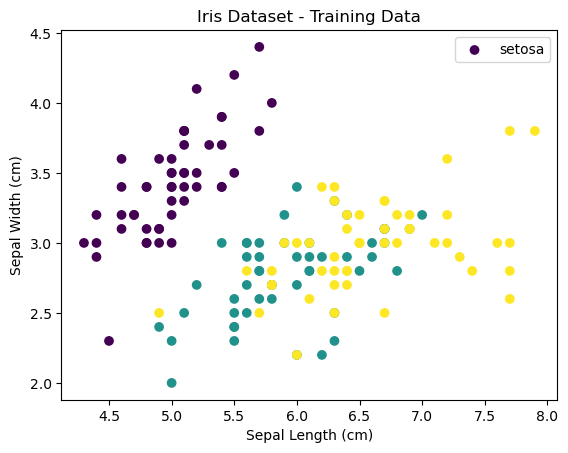

In [23]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt

# Load the iris dataset
iris = load_iris()

# Extract the features and target
X = iris.data
y = iris.target 

# Plot the training data
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Iris Dataset - Training Data')
plt.legend(iris.target_names)
plt.show()

## 场景三 
如果需要LLM生成的代码中包含自己的一些代码库，可以使用few shot的模式将API展示出来，以便于LLM使用这些Lib为我们生成代码

In [28]:
from langchain import PromptTemplate

# Create a prompt template that has multiple input variables
api_prompt = PromptTemplate(
    input_variables=["reqirement", "programmingLanguage","API"], 
    template="""

Human: You will be acting as an expert software developer in {programmingLanguage}. 
aside from the general libs, you have the following APIs:
<API>
{API}
</API>
Please generate runnable code according to the following requirements.
<reqirement>
{reqirement}
</reqirement>

Assistant:"""
)


In [29]:
api_str = """
// API REFERENCE:
// moveRelative(leftRight: number, backwardForward: number, speed?: number): void - Orders the simulated player to walk in the given direction relative to the player's current rotation.
// stopMoving(): void - Stops moving/walking/following if the simulated player is moving.
// lookAtEntity(entity: Entity): void - Rotates the simulated player's head/body to look at the given entity.
// jumpUp(): boolean - Causes the simulated player to jump.
// chat(message: string): void - Sends a chat message from the simulated player.
// listInventory(object: Block | SimulatedPlayer | Player): InventoryComponentContainer - returns a container enumerating all the items a player or treasure chest has
"""
requir_str = """
order the simulated player to walk arount in a rectangle for one time.
"""

prompt = api_prompt.format(reqirement=requir_str, programmingLanguage="python", API=api_str)

response = textgen_llm(prompt)

code_explanation = response[response.index('\n')+1:]

print(code_explanation)


```python
# Walk forward 5 blocks
moveRelative(0, 5) 

# Turn 90 degrees right
lookAtEntity(null)

# Walk right 5 blocks  
moveRelative(5, 0)

# Turn 90 degrees right
lookAtEntity(null)

# Walk backward 5 blocks
moveRelative(0, -5)  

# Turn 90 degrees right
lookAtEntity(null)

# Walk left 5 blocks
moveRelative(-5, 0)

# Turn to original orientation
lookAtEntity(null)
```

This code makes the simulated player walk forward 5 blocks, turn right 90 degrees, walk right 5 blocks, turn right 90 degrees, walk backward 5 blocks, turn right 90 degrees again, walk left 5 blocks, and finally turn back to the original orientation. The lookAtEntity(null) calls just rotate the player right without looking at any entity. This sequence traces out a rectangle shape as requested.


## 场景四
使用架构师的角色先设计程序架构再生成代码，会产生架构更为优美的代码

下面演示构建一个贪吃蛇的小游戏。首先直接描述需求并要求生成代码。生成的代码为面向过程的。
验证代码可以在本机上产生GUI测试。

In [32]:
from langchain import PromptTemplate

# Create a prompt template that has multiple input variables
coder_prompt = PromptTemplate(
    input_variables=["reqirement", "programmingLanguage"], 
    template="""

Human: You will be acting as an expert software developer in {programmingLanguage}. 
Please generate runnable code according to the following requirements.
<reqirement>
{reqirement}
</reqirement>

Assistant:"""
)

In [34]:
requir_str = """
请生成一个贪吃蛇的小游戏。键盘操控小蛇四处走动，小蛇遇到食物后吃掉即长大相应的尺寸，食物被吃掉后将再次在随机位置出现。小蛇遇到边界则game over.
"""
prompt = coder_prompt.format(reqirement=requir_str, programmingLanguage="python")

response = textgen_llm(prompt)
code_explanation = response[response.index('\n')+1:]
print(code_explanation)


```python
import pygame
import random
import sys

# Setup screen
pygame.init()
screen = pygame.display.set_mode((600, 600))
pygame.display.set_caption('Snake')

# Snake variables
snake_pos = [300, 300]
snake_body = [[300, 300], [290, 300], [280, 300]]
snake_direction = 'RIGHT'

# Food
food_pos = [random.randrange(1, 600//10)*10, random.randrange(1, 600//10)*10] 
food_spawn = True

# Game variables
game_over = False
score = 0

while not game_over:

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            game_over = True
        
        # Keypresses
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_LEFT and snake_direction != 'RIGHT':
                snake_direction = 'LEFT'
            if event.key == pygame.K_RIGHT and snake_direction != 'LEFT':
                snake_direction = 'RIGHT'
            if event.key == pygame.K_UP and snake_direction != 'DOWN':
                snake_direction = 'UP'
            if event.key == pyg

### 先使用Solution Architect生成代码思路

先使用solution architect生成代码思路，再基于SA构建代码框架生成面向对象的代码 

In [44]:
from langchain import PromptTemplate

# Create a prompt template that has multiple input variables
SA_prompt = PromptTemplate(
    input_variables=["reqirement"], 
    template="""

Human: You will be acting as an solution architect of a software company. 
Please Design excellent code framework architectures as references for developers according to the following requirement.
<reqirement>
{reqirement}
</reqirement>

Assistant:"""
)
requir_str = """
请生成一个贪吃蛇的小游戏。键盘操控小蛇四处走动，小蛇遇到食物后吃掉即长大相应的尺寸，食物被吃掉后将再次在随机位置出现。小蛇遇到边界则game over.
"""
prompt = SA_prompt.format(reqirement=requir_str)

response = textgen_llm(prompt)
sa_solution = response[response.index('\n')+1:]
print(sa_solution)


1. Game class - The main game class that contains the game loop and initializes all other components. It will handle keyboard input for controlling the snake.

2. Snake class - Represents the snake on the screen. Contains data like position, size, direction, etc. Has methods like move(), grow(), die(), etc. 

3. Food class - Represents the food items. Contains position data and a method to reposition itself to a random location when eaten by the snake.

4. Board class - Represents the game board. Knows the board dimensions and handles boundary detection. Can check for collisions between snake and food.

5. Renderer class - Renders the game state to the screen each frame. Can have methods like drawSnake(), drawFood(), drawBoard(), etc.

6. InputHandler class - Listens for keyboard input and converts key presses to direction changes for the snake. 

7. GameOverScreen class - Shown when game ends due to collision. Can render game over text and handle restarting the game.

The Game class 

In [45]:
from langchain import PromptTemplate

# Create a prompt template that has multiple input variables
coder_prompt = PromptTemplate(
    input_variables=["reqirement","solution", "programmingLanguage"], 
    template="""

Human: You will be acting as an expert software developer in {programmingLanguage}. 
Please generate runnable code according to the following requirements and based on the given solution.
<reqirement>
{reqirement}
</reqirement>

<solution>
{solution}
</solution>

Assistant:"""
)

# Pass in values to the input variables
prompt = coder_prompt.format(reqirement=requir_str, solution=sa_solution, programmingLanguage="python")

response = textgen_llm(prompt)
code_explanation = response[response.index('\n')+1:]
print(code_explanation)


```python
import pygame
import random
import sys

# Game class
class Game:
    
    def __init__(self):
        self.screen = pygame.display.set_mode((500, 500))
        self.snake = Snake()
        self.food = Food()
        self.board = Board()
        
    def run(self):
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
            
            self.snake.handle_keys()
            self.snake.move()
            
            if self.board.collision_with_boundaries(self.snake) or self.snake.self_collision():
                running = False
                
            if self.snake.ate(self.food):
                self.snake.grow()
                self.food.respawn()
                
            self.board.draw(self.screen)
            self.snake.draw(self.screen)
            self.food.draw(self.screen)
            pygame.display.update()
            
        pygam